## 03.네트워크 분석 활용

- 사용데이터 :

    - Open Street Map 데이터를 API로 참조해서 사용
    - 한국관광공사 관광데이터랩 네비게이션 데이터 활용
    -

- 작성자 : 권도희(epik5064@naver.com)

- 최종수정일 : 2025.12.19

[수정이력]
- 2025.12.15 최초작성
- 2025.12.19 내용추가

In [7]:
## 사용 라이브러리 정리
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import geopandas as gpd
from typing import Optional, Dict, Any
import time
import random

## 네트워크데이터 가져오기
import osmnx as ox

## 네트워크 분석용
import networkx as nx

## 클러스터링 등 ML 계산용
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## 시각화
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import contextily as ctx

## GIS 라이브러리
from shapely.geometry import Point

## api 요청용
import requests
from dotenv import load_dotenv

### 1. 포천시 교통네트워크 기본 분석

#### 1-1. 기본 노드링크 데이터 로드

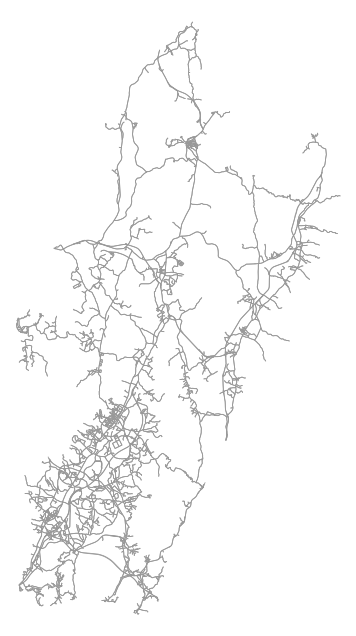

노드 수: 3844
엣지 수: 9128


In [2]:
### 포천시 노드링크 OSMnx

# 기본 설정
ox.settings.use_cache = True
ox.settings.log_console = True

# 도시 이름
place_name = "Pocheon-si, South Korea"

# 도로 네트워크 (network_type에 따라 보행, 차량용 으로 구분가능)
G = ox.graph_from_place(place_name, network_type="drive")

# 시각화
fig, ax = ox.plot_graph(
    G,
    node_size=0,
    edge_linewidth=0.6,
    bgcolor="white"
)

print(f"노드 수: {len(G.nodes)}")
print(f"엣지 수: {len(G.edges)}")

#### 1-2. 경로강제성 시각화

- 가장 많이 쓰이는 Betweenness Centrality를 활용

In [3]:
# 1) 그래프 가져오기
place_name = "Pocheon-si, South Korea"
G = ox.graph_from_place(place_name, network_type="drive")  # MultiDiGraph

# OSMnx는 기본적으로 edge['length']를 넣어줌 (추가 설정 필요 X)

# 2) edge betweenness 계산용 간단한 undirected 그래프 만들기
#    - parallel edge, 방향성은 일단 무시하고 구조만 보자
Gu = nx.Graph(G)   # MultiDiGraph -> simple Graph

# 3) edge betweenness 계산 (길이 기준)
bw_dict = nx.edge_betweenness_centrality(Gu, normalized=True, weight="length")
# bw_dict: {(u, v): 값}  (u, v)는 undirected라 (u, v) / (v, u) 동일 취급

# 4) 원래 G(MultiDiGraph)의 edge에 값 붙이기
for u, v, k, data in G.edges(keys=True, data=True):
    key = tuple(sorted((u, v)))  # undirected 키
    data["edge_bw"] = bw_dict.get(key, 0.0)

# 5) GeoDataFrame 변환
edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)

# 혹시라도 없는 컬럼 체크 (디버깅용)
print(edges_gdf.columns)
print(edges_gdf["edge_bw"].describe())

Index(['osmid', 'highway', 'oneway', 'reversed', 'length', 'edge_bw', 'lanes',
       'name', 'geometry', 'ref', 'bridge', 'maxspeed', 'tunnel', 'width',
       'access', 'junction'],
      dtype='object')
count    9128.000000
mean        0.010857
std         0.025578
min         0.000000
25%         0.000520
50%         0.001560
75%         0.007069
max         0.200824
Name: edge_bw, dtype: float64


c:\Users\user\Desktop\AI 및 머신러닝\LLM-Geo-master\LLM-Geo-master\.conda\lib\site-packages\contextily\tile.py:662: UserWarning: The inferred zoom level of 28 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


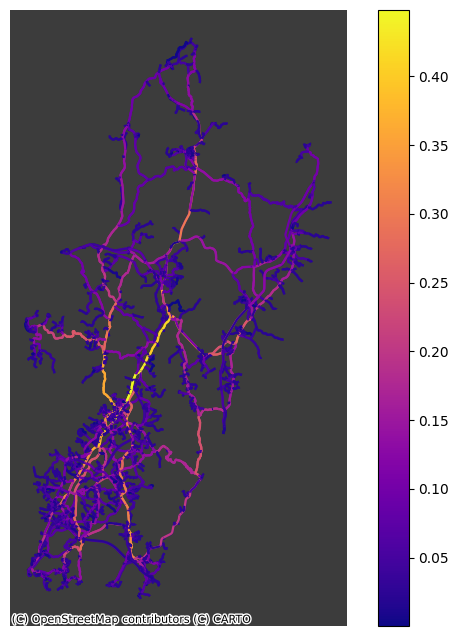

In [4]:
#좌표계 설정
edges_gdf = edges_gdf.to_crs(epsg=4326)
# 시각화를 위해 루트처리
fig.patch.set_facecolor("#9E9999") 
ax.set_facecolor("#111111")          
edges_gdf["bw_sqrt"] = np.sqrt(edges_gdf["edge_bw"])

# 6) 플롯
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# (2) betweenness가 있는 edge만 색칠
edges_gdf.loc[edges_gdf["bw_sqrt"] > 0].plot(
    ax=ax,
    column="bw_sqrt",
    cmap="plasma",
    linewidth=1.6,
    legend=True,
    zorder=2
)
# ✅ 실제 지도 배경
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.DarkMatter,  # 어두운 배경
    alpha=0.9
)

ax.set_axis_off()
#plt.tight_layout()
plt.show()

중심 간선도로를 많이 지나갈수밖에 없는 형상을 보임

### 2. 관광지 데이터 추가분석

In [11]:
## 포천시 네비게이션 검색 상위 20개 

pocheon_poi = pd.read_csv('./data/포천시네비게이션검색순위_202510.csv')
pocheon_poi = pocheon_poi.head(20)

pocheon_poi

,순위,광역시/도,시/군/구,관광지명,중분류 카테고리,소분류 카테고리,검색건수,도로명주소,지번주소
0,1,경기도,포천시,산정호수,자연관광,자연경관(하천/해양),23711,NaN,경기 포천시 영북면 산정리
1,2,경기도,포천시,한탄강Y자출렁다리,기타관광,기타관광,22999,NaN,경기 포천시 영북면 대화산리 256
2,3,경기도,포천시,국립수목원,문화관광,테마공원,16762,NaN,경기 포천시 소홀읍 작동리 50-18
3,4,경기도,포천시,포천한탄강가든페스타,문화관광,기타문화관광지,15082,경기 포천시 관인면 창동로 832,경기 포천시 관인면 중리 526-1
4,5,경기도,포천시,포천아트밸리,문화관광,공연시설,14788,NaN,경기 포천시 신북면 기지리 282
5,6,경기도,포천시,허브아일랜드,체험관광,농/산/어촌체험,13293,NaN,경기 포천시 신북면 삼정리 517 2
6,7,경기도,포천시,포천힐마루CC,레저스포츠,육상레저스포츠,13131,NaN,경기 포천시 영중면 거사리 105
7,8,경기도,포천시,베어크리크GC,레저스포츠,육상레저스포츠,11791,NaN,경기 포천시 화현면 지현리 2 1
8,9,경기도,포천시,포천힐스CC,레저스포츠,육상레저스포츠,11078,NaN,경기 포천시 군내면 상성북리 34-1
9,10,경기도,포천시,필로스GC,레저스포츠,육상레저스포츠,10756,NaN,경기 포천시 일동면 기산리 142 1


In [35]:
load_dotenv("./.gitignore/vworld_API_KEY.env")
vworld_API_KEY = os.getenv("vworld_API_KEY")
if not vworld_API_KEY:
    raise RuntimeError("환경변수 vworld_API_KEY가 없음.")

def vworld_geocode(query, key=vworld_API_KEY):
    """
    관광지명(키워드)로 장소 검색 → 주소(road_address_name 우선, 없으면 address_name) 추출
    """
    url = "https://api.vworld.kr/req/address?"
    params = {
        "service": "address",
        "request": "getcoord",
        "version": "2.0",
        "crs": "EPSG:4326",
        "address": query,
        "type": "PARCEL",   
        "size": 1,
        "format": "json",
        "key": key,
    }
    r = requests.get(url, params=params, timeout=5).json()
    print(r)
    try:
        p = r["response"]["result"]["point"]
        return float(p["y"]), float(p["x"])  # lat, lon
    except:
        return None, None

# -------------------------
# 사용 예시
# -------------------------

pocheon_poi["lat"], pocheon_poi["lon"] = zip(*pocheon_poi["지번주소"].apply(vworld_geocode))
time.sleep(0.1)

{'response': {'service': {'name': 'address', 'version': '2.0', 'operation': 'getcoord', 'time': '22(ms)'}, 'status': 'OK', 'input': {'type': 'PARCEL', 'address': '경기 포천시 영북면 산정리'}, 'refined': {'text': '경기도 포천시 영북면 산정리 1', 'structure': {'level0': '대한민국', 'level1': '경기도', 'level2': '포천시', 'level3': '', 'level4L': '영북면', 'level4LC': '4165039023100010000', 'level4A': '', 'level4AC': '', 'level5': '1', 'detail': ''}}, 'result': {'crs': 'EPSG:4326', 'point': {'x': '127.35488440203153', 'y': '38.08567618486825'}}}}
{'response': {'service': {'name': 'address', 'version': '2.0', 'operation': 'getcoord', 'time': '21(ms)'}, 'status': 'NOT_FOUND', 'record': {'total': '0', 'current': '0'}, 'page': {'total': '1', 'current': '1', 'size': '10'}}}
{'response': {'service': {'name': 'address', 'version': '2.0', 'operation': 'getcoord', 'time': '25(ms)'}, 'status': 'NOT_FOUND', 'record': {'total': '0', 'current': '0'}, 'page': {'total': '1', 'current': '1', 'size': '10'}}}
{'response': {'service': {'name'

In [39]:
pocheon_poi.to_csv('./data/포천시네비게이션검색순위_202510_processed.csv', encoding='cp949')

api로 검색이 불가능한 경우 직접 처리

In [5]:
## 전처리 완료된 데이터를 다시 불러오기

pocheon_poi = pd.read_csv('./data/포천시네비게이션검색순위_202510_processed.csv', encoding='cp949')

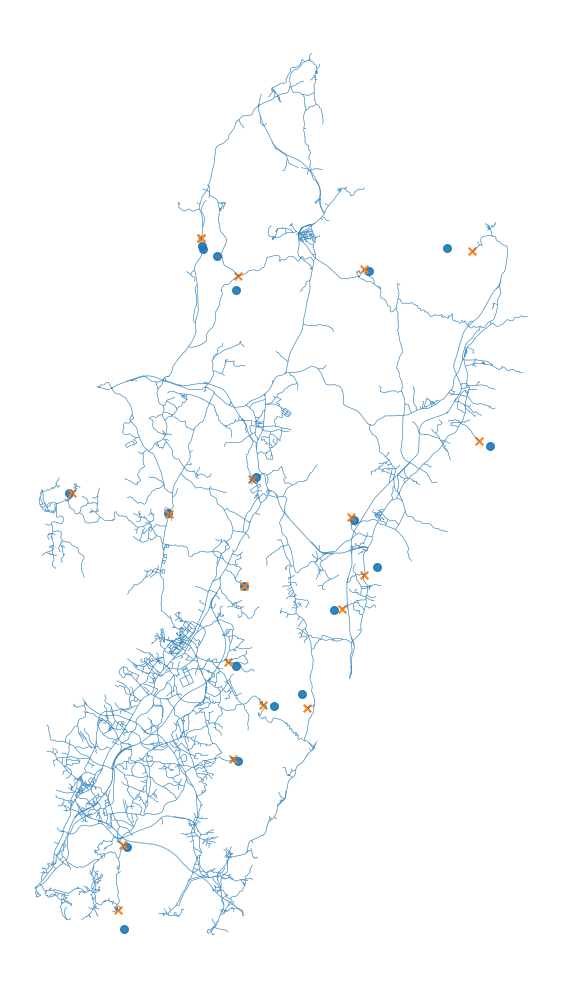

In [6]:
## 관광지별로 가장 가까운 노드를 시각화
# 1) 그래프 → GeoDataFrame
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# 2) 관광지 → GeoDataFrame (WGS84)
spots_gdf = gpd.GeoDataFrame(
    pocheon_poi.copy(),
    geometry=gpd.points_from_xy(pocheon_poi["lon"], pocheon_poi["lat"]),
    crs="EPSG:4326"
)

# 3) 관광지별 가장 가까운 노드(osmid) 구하고, 그 노드만 추출
spots_gdf["nearest_node"] = ox.distance.nearest_nodes(
    G, X=spots_gdf.geometry.x, Y=spots_gdf.geometry.y
)
nearest_nodes_gdf = nodes_gdf.loc[spots_gdf["nearest_node"].values].copy()

# 4) 시각화 (WGS84 그대로 그려도 되지만, 보기 좋게 metric으로 투영 권장)
proj_crs = edges_gdf.estimate_utm_crs()
edges_p = edges_gdf.to_crs(proj_crs)
nodes_p = nodes_gdf.to_crs(proj_crs)
spots_p = spots_gdf.to_crs(proj_crs)
near_p = nearest_nodes_gdf.to_crs(proj_crs)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
edges_p.plot(ax=ax, linewidth=0.4, alpha=0.6)
spots_p.plot(ax=ax, markersize=30, alpha=0.9)        # 관광지 점
near_p.plot(ax=ax, markersize=30, marker="x")        # 가장 가까운 노드 (X)

# (선택) 관광지-최근접노드 연결선
# gpd.GeoSeries(
#     [Point(a).buffer(0).centroid for a in []], crs=proj_crs
# )
# for p, n in zip(spots_p.geometry, near_p.geometry):
#     ax.plot([p.x, n.x], [p.y, n.y], linewidth=0.6, alpha=0.7)

ax.set_axis_off()
plt.tight_layout()
plt.show()

#### 2-1. 각 관광지로 향하는 경로에서 가장 많이 지나야 하는 길

- 관광목적으로 향하는 경우 도로구조의 부하가 높은 곳은 어디인가?

- 단순화를 위해 출발지는 랜덤으로 생성 (실제로는 남/남서 외부노드에서 출발하는 비중을 늘려야 하나, 단순화를 위해 구분하지 않음)

- 네트워크 구조상의 부하량을 확인하기 위함이므로, 각 관광지로 향하는 차량의 대수는 고려하지 않음

- 평행엣지 문제(같은 노드간 연결인데 엣지가 여러개인 경우)는 현 단계에서 고려하지 않음. 최단경로를 대표 엣지로 선택

In [11]:


# 1) MultiDiGraph -> (u,v) 단일엣지 DiGraph로 압축 (평행엣지는 length 최소인 key를 대표로)
def make_compact_digraph(G, weight="length"):
    H = nx.DiGraph()
    # (u,v) -> 선택된 key 저장 (나중에 edges_gdf에서 geometry 가져오기 위함)
    uv_to_key = {}

    for u, v, k, data in G.edges(keys=True, data=True):
        w = data.get(weight, None)
        if w is None:
            continue

        # 이미 (u,v)가 있으면 더 짧은 엣지로 교체
        if H.has_edge(u, v):
            if w < H[u][v][weight]:
                H[u][v][weight] = w
                uv_to_key[(u, v)] = k
        else:
            H.add_edge(u, v, **{weight: w})
            uv_to_key[(u, v)] = k

    return H, uv_to_key


# ------------------------------------------------------------
# 2) 랜덤 출발지 노드 샘플링 (관광지 노드 제외)
def sample_origin_nodes(G, n_origins=200, exclude_nodes=None, seed=42):
    rng = random.Random(seed)
    nodes = list(G.nodes)
    if exclude_nodes:
        exclude = set(exclude_nodes)
        nodes = [n for n in nodes if n not in exclude]
    # 중복 없이 샘플
    n = min(n_origins, len(nodes))
    return rng.sample(nodes, n)


# ------------------------------------------------------------
# 3) 최단경로에서 엣지 카운팅
# - per-destination: 관광지별로 많이 쓰이는 (u,v)
# - global: 모든 관광지/출발지를 합친 (u,v)
def count_edge_overlap(H, origins, destinations, weight="length"):
    per_dest_counts = {}   # dest -> Counter dict {(u,v): count}
    global_counts = {}     # {(u,v): count}

    for d in destinations:
        c = {}
        for o in origins:
            if o == d:
                continue
            try:
                path = nx.shortest_path(H, source=o, target=d, weight=weight)
            except (nx.NetworkXNoPath, nx.NodeNotFound):
                continue

            # node path -> edge path
            for u, v in zip(path[:-1], path[1:]):
                c[(u, v)] = c.get((u, v), 0) + 1
                global_counts[(u, v)] = global_counts.get((u, v), 0) + 1

        per_dest_counts[d] = c

    return per_dest_counts, global_counts


# ------------------------------------------------------------
# 4) 결과를 DataFrame / GeoDataFrame으로 만들기


def counts_to_gdf(edges_gdf, counts_dict, uv_to_key, proj_crs=None, top_k=30):
    """
    counts_dict: {(u,v): count}
    uv_to_key: (u,v) -> key
    """
    rows = []
    for (u, v), cnt in counts_dict.items():
        k = uv_to_key.get((u, v), None)
        if k is None:
            continue

        # MultiIndex: (u, v, key)
        if (u, v, k) not in edges_gdf.index:
            continue

        geom = edges_gdf.loc[(u, v, k), "geometry"]
        length = edges_gdf.loc[(u, v, k), "length"] if "length" in edges_gdf.columns else np.nan

        rows.append({"u": u, "v": v, "key": k, "count": cnt, "length": length, "geometry": geom})

    out = gpd.GeoDataFrame(rows, geometry="geometry", crs=edges_gdf.crs)
    if out.empty:
        return out

    out = out.sort_values("count", ascending=False).head(top_k).reset_index(drop=True)

    if proj_crs is None:
        proj_crs = out.estimate_utm_crs()
    out = out.to_crs(proj_crs)

    return out




In [24]:
## 앞선 시각화 코드에서 추출
## 관광지에서 가장 가까운 노드
dest_nodes = spots_gdf["nearest_node"].tolist()

H, uv_to_key = make_compact_digraph(G, weight="length")

origin_nodes = sample_origin_nodes(H, n_origins=300, exclude_nodes=dest_nodes, seed=7)

nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

per_dest_counts, global_counts = count_edge_overlap(H, origin_nodes, dest_nodes, weight="length")

# 전체(모든 관광지)에서 가장 많이 겹치는 도로 Top-K
proj_crs = edges_gdf.estimate_utm_crs()
global_top_edges = counts_to_gdf(edges_gdf, global_counts, uv_to_key, proj_crs=proj_crs, top_k=100)

# 관광지별 Top-K도 만들고 싶으면:
# dest_top_edges = {d: counts_to_gdf(edges_gdf, per_dest_counts[d], uv_to_key, proj_crs=proj_crs, top_k=30)
#                   for d in dest_nodes}

# ------------------------------------------------------------


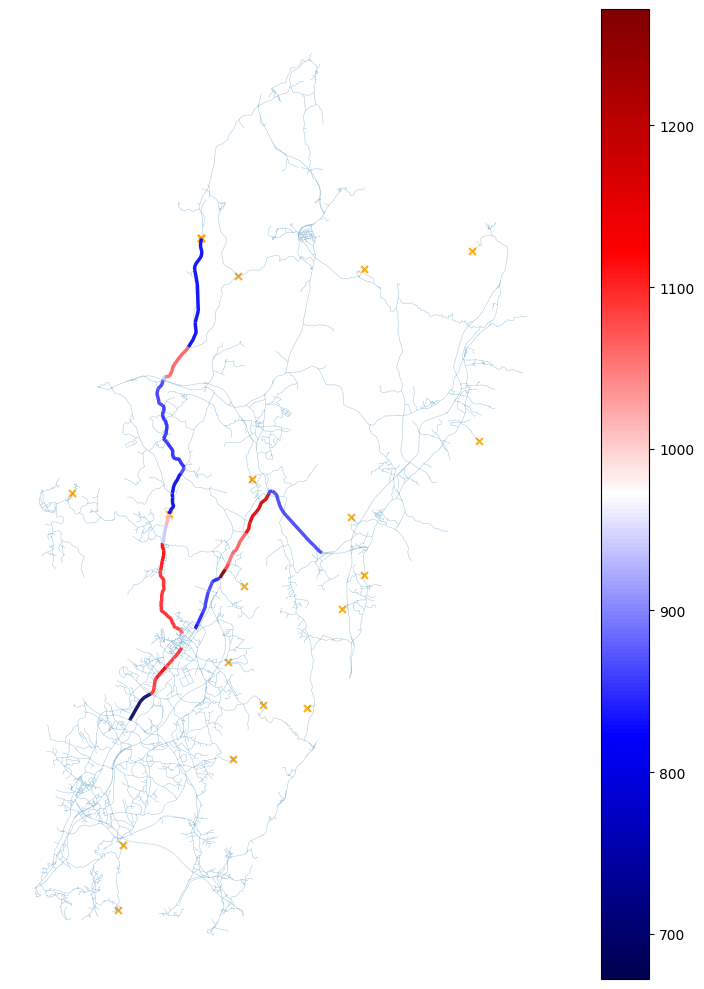

,u,v,key,count,length
0,436677536,7125401919,0,1272,537.598340
1,436615781,436615783,0,1255,59.085727
2,9045167546,436615781,0,1174,1170.633207
3,9045167553,9045167546,0,1162,621.117534
4,436677626,9045167789,0,1147,428.510875
5,9045167567,9045167553,0,1138,614.427896
6,13050280683,436756578,0,1128,289.930080
7,13050280691,13050280683,0,1128,275.696477
8,436756578,436756586,0,1121,407.055308
9,13050280542,13050280691,0,1114,493.475212


In [25]:
# 5) 시각화: 전체 겹침 Top 도로 하이라이트
edges_p = edges_gdf.to_crs(proj_crs)
spots_p = spots_gdf.to_crs(proj_crs)
near_p = nodes_gdf.loc[dest_nodes].to_crs(proj_crs)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
edges_p.plot(ax=ax, linewidth=0.3, alpha=0.25)              # 전체 도로
if not global_top_edges.empty:
    global_top_edges.plot(ax=ax,column="count",cmap="seismic", linewidth=2.5, alpha=0.9, legend=True)  # 겹침 상위 도로 (굵게)
# spots_p.plot(ax=ax, markersize=25, alpha=0.8)               # 관광지(원 좌표)
near_p.plot(ax=ax, markersize=25, marker="x", alpha=0.9, color='orange')    # 관광지 대응 노드

ax.set_axis_off()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 6) 표로도 확인 (상위 20개)
display(global_top_edges.drop(columns="geometry").head(20))

- 실제 경로강제성이 높은 도로와 일부 일치하는 경향을 보임

#### 2-2. 유입경로를 외부노드 기준으로 식별

- 외부에서 포천시의 각 관광지로 향하는 경우에 발생하는 경로 집중도

- 남/남서쪽 외부노드(서울, 동두천, 양주, 의정부 등)에서 유입이 많다고 가정하는경우, 출발지 비율을 해당 부분에 늘려서 비교

In [ ]:

def sample_origins_s_sw_boundary(
    nodes_p,               # nodes_gdf.to_crs(proj_crs) 결과 (index= osmid)
    n_origins=300,
    exclude_nodes=None,    # 관광지 노드 등 제외
    boundary_q=0.12,       # 외곽 판정(아래쪽 y 하위 12% 정도)
    sector_boost=6.0,      # 남/남서 섹터 가중치
    boundary_boost=3.0,    # 외곽 가중치
    seed=7
):
    """
    nodes_p: columns에 x,y(또는 geometry) 있어야 함 (OSMnx nodes_gdf는 x,y 있음)
    남/남서(S~SW) + 외곽(boundary)로 출발지 확률을 편향시켜 샘플링
    """
    rng = np.random.default_rng(seed)

    df = nodes_p.copy()

    # x,y 확보 (OSMnx nodes_gdf 기본 컬럼)
    if "x" not in df.columns or "y" not in df.columns:
        df["x"] = df.geometry.x
        df["y"] = df.geometry.y

    # 제외 노드 제거
    if exclude_nodes is not None:
        exclude_nodes = set(exclude_nodes)
        df = df.loc[~df.index.isin(exclude_nodes)].copy()

    # ---- (1) 외곽 후보 풀 만들기: 남쪽 외곽 + 남서쪽 외곽 조금 포함
    y_thr = df["y"].quantile(boundary_q)          # 남쪽 경계
    x_thr = df["x"].quantile(boundary_q)          # 서쪽 경계(남서 보강용)

    # 남쪽 외곽 + (서쪽이면서 중하단인) 남서 성분 조금 포함
    boundary_mask = (df["y"] <= y_thr) | ((df["x"] <= x_thr) & (df["y"] <= df["y"].quantile(0.50)))
    cand = df.loc[boundary_mask].copy()

    # 후보가 너무 적으면 외곽 기준을 완화
    if len(cand) < n_origins:
        boundary_mask = (df["y"] <= df["y"].quantile(0.20)) | ((df["x"] <= df["x"].quantile(0.20)) & (df["y"] <= df["y"].quantile(0.60)))
        cand = df.loc[boundary_mask].copy()

    # ---- (2) 남/남서 섹터 가중치: 중심 기준 각도 계산 (0=동, 90=북, 180=서, 270=남)
    cx, cy = df["x"].mean(), df["y"].mean()
    ang = np.degrees(np.arctan2(cand["y"] - cy, cand["x"] - cx))
    ang = (ang + 360) % 360  # 0~360

    # 남/남서: 대략 200~290도 (SW(225)~S(270) 중심)
    sector_mask = (ang >= 200) & (ang <= 290)

    # 가중치 구성
    w = np.ones(len(cand), dtype=float)
    w *= boundary_boost                    # 외곽 후보 자체에 기본 가중치
    w[sector_mask.values] *= sector_boost  # 남/남서면 추가 증폭

    # 확률로 샘플링(중복 없이)
    w = w / w.sum()
    n = min(n_origins, len(cand))
    origins = rng.choice(cand.index.values, size=n, replace=False, p=w)

    return origins

nodes_p = nodes_gdf.to_crs(proj_crs)
origin_nodes = sample_origins_s_sw_boundary(
    nodes_p,
    n_origins=300,
    exclude_nodes=dest_nodes,   # 관광지 대응 노드 제외
    boundary_q=0.12,
    sector_boost=6.0,
    boundary_boost=3.0,
    seed=7
)

print(len(origin_nodes), origin_nodes[:5])


300 [ 9710792914 11054911345  9756821448  4658743282  5732149216]


In [27]:
per_dest_counts, global_counts = count_edge_overlap(H, origin_nodes, dest_nodes, weight="length")

# 전체(모든 관광지)에서 가장 많이 겹치는 도로 Top-K
proj_crs = edges_gdf.estimate_utm_crs()
global_top_edges = counts_to_gdf(edges_gdf, global_counts, uv_to_key, proj_crs=proj_crs, top_k=40)

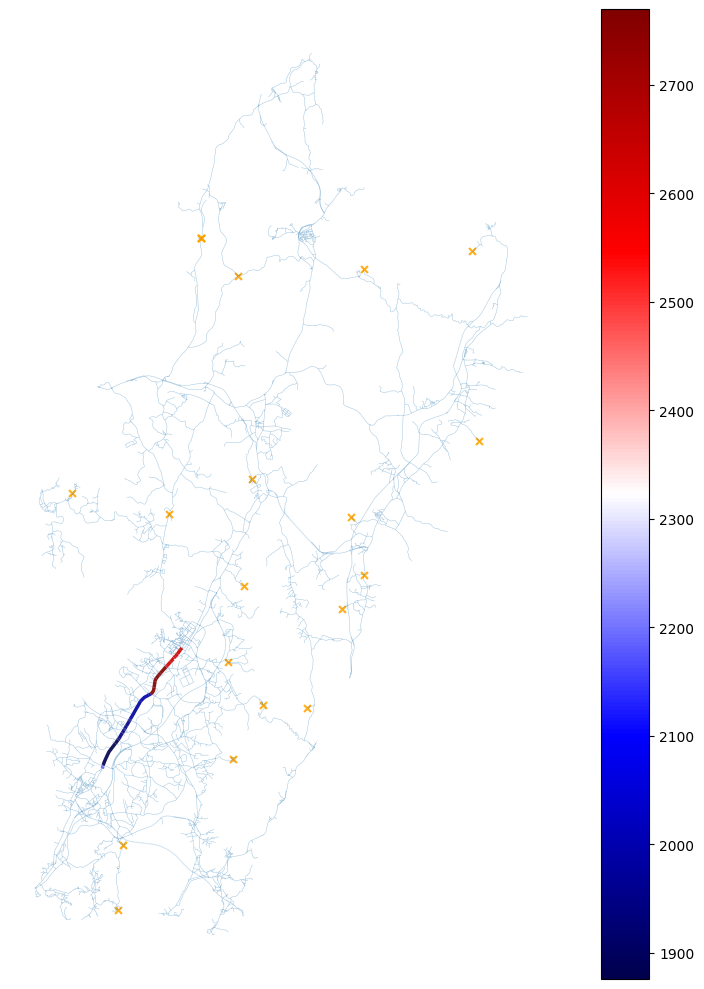

,u,v,key,count,length
0,10949323735,10964960910,0,2770,335.624340
1,436677665,10949323735,0,2770,406.499891
2,436677637,10076155638,0,2770,224.144922
3,10964960910,436677637,0,2770,156.036723
4,436677626,9045167789,0,2770,428.510875
5,10076155638,436677626,0,2770,144.891812
6,9045167755,9045167749,0,2624,10.179423
7,9045167749,4634683692,0,2624,84.660827
8,11043433136,436677615,0,2624,230.680621
9,9045167788,11043433136,0,2624,264.358081


In [28]:
# 5) 시각화: 전체 겹침 Top 도로 하이라이트
edges_p = edges_gdf.to_crs(proj_crs)
spots_p = spots_gdf.to_crs(proj_crs)
near_p = nodes_gdf.loc[dest_nodes].to_crs(proj_crs)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
edges_p.plot(ax=ax, linewidth=0.3, alpha=0.25)              # 전체 도로
if not global_top_edges.empty:
    global_top_edges.plot(ax=ax,column="count",cmap="seismic", linewidth=2.5, alpha=0.9, legend=True)  # 겹침 상위 도로 (굵게)
# spots_p.plot(ax=ax, markersize=25, alpha=0.8)               # 관광지(원 좌표)
near_p.plot(ax=ax, markersize=25, marker="x", alpha=0.9, color='orange')    # 관광지 대응 노드

ax.set_axis_off()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 6) 표로도 확인 (상위 20개)
display(global_top_edges.drop(columns="geometry").head(20))

- 구조상으로 남/남서 방향에서 포천시 관광지로 유입되는 경로들은 중앙부의 특정 간선을 반복적으로 경유하는 경향을 보임